## Libraries

In [23]:
import torch
import numpy as np
import random
import math
import copy
import sys
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms



## Loading Data for SGD

In [24]:
#Code adapted from lab and pytorch tutorial
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Set the batch size
batch_size = 64

# Download and prepare the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the original training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Create data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Lenet

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## AlexNet

In [ ]:
# code adapted from this paper https://ieeexplore.ieee.org/document/9696076
#Rest of code uses LeNet model not AlexNet so do not run without changing further code
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 28*2, 3, stride= 1, padding='same')
#         self.pool = nn.MaxPool2d(3 , stride = 2)
#         self.conv2 = nn.Conv2d(28*2, 64*2, 5, stride = 1, padding = 'same')
#         self.conv3 = nn.Conv2d(64*2, 96*2, 3, stride = 1, padding = 'same')
#         self.conv4 = nn.Conv2d(96*2, 96*2, 3, stride = 1, padding ='same')
#         self.conv5 = nn.Conv2d(96*2, 64*2, 3, stride = 1, padding='same' )
#         self.fc1 = nn.Linear(64*2*3*3, 1024*2)
#         self.fc2 = nn.Linear(1024*2, 1024*2)
#         self.fc3 = nn.Linear(1024*2, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pool(F.relu(self.conv5(x)))
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, 0.5)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# #device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# net = Net()
# #net.to(device)

## SGD

In [26]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)

In [27]:
#calculate accuracy using validation set
def accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(valloader,0):
            inputs, images = data[0].to(device), data[1].to(device)
            #inputs, images = data
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += images.size(0)
            correct += (predicted == images).sum().item()

    print(f'Accuracy: {100 * correct // total} %')
    return (100 * correct // total)

In [29]:

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        #inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

print(accuracy(net))


KeyboardInterrupt: ignored

Gradient Descent For Last Layer

In [ ]:
#randomise last layer
net.fc3.weight = nn.Parameter(torch.from_numpy(np.random.rand(10,84).astype('float32')))
net.fc3.bias = nn.Parameter(torch.from_numpy(np.random.rand(10).astype('float32')))
net.to(device)
for param in net.parameters():
  param.requires_grad = False
for param in net.fc3.parameters():
  param.requires_grad = True


In [ ]:
#move optimiser back to gpu
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)

In [ ]:

accuracyList1 = []

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    temp = accuracy(net)
    accuracyList1.append((epoch, temp))

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        #inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()




Accuracy: 9 %
Accuracy: 50 %
Accuracy: 56 %
Accuracy: 58 %
Accuracy: 58 %
Accuracy: 59 %
Accuracy: 60 %
Accuracy: 60 %
Accuracy: 60 %
Accuracy: 60 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 61 %
Accuracy: 61 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 62 %
Accuracy: 6

## Reintialising the batch size for IMP-GWO

In [30]:

# Set the batch size
batch_size = 10000

# Download and prepare the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the original training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Create data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Wolf Class

In [31]:
class wolf:
    def __init__(self, fitness, dim, minx, maxx, seed, inputs, labels):
        self.random = random.Random(seed)
        self.position = np.zeros(dim)
        for i in range(dim):
            self.position[i] = ((maxx - minx) * self.random.random() + minx)
        self.fitness = fitness(self.position, inputs, labels)

## IMP-GWO

In [32]:

#Code adapted from https://uk.mathworks.com/matlabcentral/fileexchange/81253-improved-grey-wolf-optimizer-i-gwo
accuracyList2 = []
def imp_gwo(fitness, max_iter, n, dim, minx, maxx):
    list_performance = []
    rnd = random.Random()
    #rnd = random.rand()

    # Convert trainloader to a list
    train_batches = list(trainloader)
    # Get a random batch
    random_batch = random.choice(train_batches)
    # Extract inputs and labels from the random batch
    inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

    #populating the intial population of grey wolves
    population = [ wolf(fitness, dim, minx, maxx, i, inputs, labels) for i in range (n)]

    #sort the population using the fitness function
    population = sorted(population, key = lambda temp: temp.fitness)

    copy_population = copy.copy(population)

    Iter = 0
    while Iter < max_iter:

        # Convert trainloader to a list
        train_batches = list(trainloader)
        # Get a random batch
        random_batch = random.choice(train_batches)
        # Extract inputs and labels from the random batch
        inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

        #assign the best fitness to the three wolves
        alpha, beta, delta = copy.copy(population[:3])

        if Iter % 2 == 0 and Iter > 1:
            print("Iter = " + str(Iter) + " best fitness = %.3f" % alpha.fitness)

        for i in range(n):


            #linearly decreasing a, which goes down from 2 to 0
            a = 2 - ((2 * Iter)/max_iter)

            #a1,a2,a3 does match the equation given on the paper
            A1, A2, A3 = a * (2 * rnd.random() - 1), a * (2 * rnd.random() - 1), a * (2 * rnd.random() - 1)
            C1, C2, C3 = 2 * rnd.random(), 2 * rnd.random(), 2 * rnd.random()

            #intialising the variables x1,x2,x3,Xnew
            X1 = np.zeros(dim)
            X2 = np.zeros(dim)
            X3 = np.zeros(dim)
            Xgwo = np.zeros(dim)

            for j in range(dim):
                X1[j] = alpha.position[j] - A1 * abs(C1 * alpha.position[j] - population[i].position[j])
                X2[j] = beta.position[j] - A2 * abs(C2 * beta.position[j] - population[i].position[j])
                X3[j] = delta.position[j] - A3 * abs(C3 * delta.position[j] - population[i].position[j])

            Xgwo = (X1 + X2 + X3) / 3

            R = np.linalg.norm(population[i].position - Xgwo)

            neigh = []

            for p in range(n):
                if(np.linalg.norm(population[i].position - copy_population[p].position) < R):
                    neigh.append(copy_population[p].position)

            Ximpgwo = np.zeros(dim)

            for z in range(dim):
                random_index_neigh = np.random.randint(0, len(neigh))
                random_index_population = np.random.randint(0, len(population))
                Ximpgwo[z] = population[i].position[z] + rnd.random() * (neigh[random_index_neigh][z] - population[random_index_population].position[z])

            Xgwo_fitness = fitness(Xgwo, inputs, labels)
            Ximpgwo_fitness = fitness(Ximpgwo, inputs, labels)

            if((Xgwo_fitness < Ximpgwo_fitness) and (Xgwo_fitness < population[i].fitness)):
                population[i].position = Xgwo
                population[i].fitness = Xgwo_fitness
            elif((Ximpgwo_fitness < Xgwo_fitness) and (Ximpgwo_fitness < population[i].fitness)):
                population[i].position = Ximpgwo
                population[i].fitness = Ximpgwo_fitness


        population = sorted(population, key = lambda temp: temp.fitness)
        #assign the best fitness to the three wolves
        alpha, beta, delta = copy.copy(population[:3])
        accuracyList2.append((Iter,accuracyGWO(alpha.position)))
        list_performance.append((Iter,alpha.fitness))
        Iter += 1
    return accuracyList2, list_performance

### Fitness Function

In [33]:
def fitness(wolf, inputs, labels):
    total_loss = 0
    wolf = wolf.astype('float32')
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(wolf[:850-10].reshape(10,84)))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(wolf[-10:]))
    net.fc3.to(device)
    with torch.no_grad():
        out = net(inputs)
        loss = criterion(out, labels)
        total_loss+= loss.item()
    return total_loss


In [34]:
def accuracyGWO(wolf):
    wolf = wolf.astype('float32')
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(wolf[:840].reshape(10,84)))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(wolf[-10:]))
    net.fc3.to(device)
    correct = 0
    total = 10000

    with torch.no_grad():
        for i, data in enumerate(valloader,0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 validation images: {100 * correct // total} %')
    return (100 * correct // total)

In [35]:
f = fitness
# IMP_GWO(FITNESS FUNCTION, MAX_ITER, POPULATION_SIZE, DIM, MIN, MAX) RETURNS ALPHA'S POSITION
imp_gwo(f, 100 , 300, 850, -1, 1)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 validation images: 17 %


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90><function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Accuracy of the network on the 10000 validation images: 20 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

KeyboardInterrupt: ignored

### Testing the model with the test set (IMP-GWO)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cae75152950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cae75152950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 test images: 46 %


## Genetic Algorithm

In [ ]:
# Convert trainloader to a list
train_batches = list(trainloader)
# Get a random batch
random_batch = random.choice(train_batches)
# Extract inputs and labels from the random batch
inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cae75152950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cae75152950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

In [ ]:
#Code adapted from labs
import random
import numpy as np
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
from deap import creator, base, tools, algorithms


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 300 #Population size
dimension   = 850 #Number of decision variable x
numOfBits   = 30 #Number of bits in the decision variable
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 3 #number of elite individuals selected
crossProb   = 0.85
flipProb    = 1. / (dimension * numOfBits/35) #bit mutate prob
mutateprob  = .9 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....
accuracyList3 = []
toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)


toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_bool, numOfBits*dimension)


toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_network(inputs, labels, individual):
    total_loss = 0
    sep = separatevariables(individual)
    sep = np.asarray(sep)
    sep = sep.astype('float32')
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(sep[:840].reshape(10,84)))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(sep[-10:]))
    net.to(device)
    with torch.no_grad():
      out = net(inputs)
      loss = criterion(out, labels)
      total_loss+= loss.item()
    return (1.0/(0.01+total_loss)),


def accuracyGA(individual):
    sep = separatevariables(individual)
    sep = np.asarray(sep)
    sep = sep.astype('float32')
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(sep[:840].reshape(10,84)))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(sep[-10:]))
    net.to(device)
    correct = 0
    total = 10000
    with torch.no_grad():
      for data in valloader:
        inp, test = data[0].to(device), data[1].to(device)
        outputs = net(inp)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == test).sum().item()

    print(f'Accuracy of the network on the 10000 validation images: {100 * correct // total} %')
    return (100 * correct // total)


#-------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", eval_network, inputs, labels)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-5+10*numasint/maxnum
    return numinrange

# input: concatenated list of binary variables
# output: tuple of real numbers representing those variables
def separatevariables(v):
    variablelist = []
    for i in range(0,dimension):
        variablelist.append(chrom2real(v[numOfBits*i:numOfBits*(i+1)]))

    return variablelist

def real2chrom(weight):
    #print("in real2chrom ",weight)
    weight=weight/20
    if weight<-1:
        weight=-1
    if weight>1:
        weight=1
    integerPart = int(maxnum * (weight + 1) / 2)
    if (integerPart == maxnum):
        integerPart -= 1
    chromosome = [int(d) for d in str(bin(integerPart))[2:]]
    while (len(chromosome) < numOfBits):
        chromosome.insert(0,0)
    indasstring=''.join(map(str, chromosome))
    chromosome=bin_to_gray(indasstring)
    output=[]
    for digit in chromosome:
        output.append(int(digit))
    #print("out",chrom2real(chromosome))
#     print(chromosome)
#     if False in chromosome:
#         print ("got false")
    return output


def main():
    #random.seed(64)
    # create an initial population of individuals (where
    # each individual is a list of integers
    # Convert trainloader to a list

    popa = toolbox.population(n=popSize)
    pop=[]
    for ind in popa:
        sep=separatevariables(ind)
        weightlist=[]
        for weight in sep:
            weightlist+=real2chrom(weight)#/20)
        #print(weightlist)
        pop.append(creator.Individual(weightlist))

    # Convert trainloader to a list
    train_batches = list(trainloader)
    # Get a random batch
    random_batch = random.choice(train_batches)
    # Extract inputs and labels from the random batch
    inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

    fitnesses = list(map(toolbox.evaluate, pop))


    #print(fitnesses)

    for ind, fit in zip(pop, fitnesses):
        #print(ind, fit)
        ind.fitness.values = fit


    # Extracting all the fitnesses of
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0

    # chromosone is 1 weight, an individual is 850 weights
    # Begin the evolution

    while g < iterations:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)


        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop,len(pop)-nElitists)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

#         for individ in offspring:
#             print(individ)


        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[3::2], offspring[4::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                #print('before crossover ',child1, child2)
                toolbox.mate(child1, child2)
                #print('after crossover ',child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring[8:]:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values


        # Convert trainloader to a list
        train_batches = list(trainloader)
        # Get a random batch
        random_batch = random.choice(train_batches)
        # Extract inputs and labels from the random batch
        inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        #print("  Evaluated %i individuals" % len(invalid_ind))

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        best_ind = tools.selBest(pop, 1)[0]
        print(best_ind.fitness.values)
        accuracyList3.append((g, accuracyGA(best_ind)))


    print("-- End of (successful) evolution --")

    best_ind = tools.selBest(pop, 1)[0]
    print(best_ind.fitness.values)

if __name__ == "__main__":
    main()

Accuracy of GA on test set

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 38 %


In [ ]:
print(accuracyList1)
print(accuracyList2)
print(accuracyList3)

[(0, 9), (1, 50), (2, 56), (3, 58), (4, 58), (5, 59), (6, 60), (7, 60), (8, 60), (9, 60), (10, 61), (11, 61), (12, 61), (13, 61), (14, 61), (15, 61), (16, 61), (17, 61), (18, 61), (19, 61), (20, 61), (21, 61), (22, 61), (23, 62), (24, 61), (25, 62), (26, 61), (27, 61), (28, 61), (29, 62), (30, 62), (31, 61), (32, 62), (33, 62), (34, 62), (35, 62), (36, 62), (37, 62), (38, 61), (39, 62), (40, 61), (41, 62), (42, 62), (43, 62), (44, 62), (45, 62), (46, 62), (47, 62), (48, 62), (49, 62), (50, 61), (51, 61), (52, 62), (53, 62), (54, 62), (55, 62), (56, 62), (57, 62), (58, 62), (59, 62), (60, 62), (61, 62), (62, 62), (63, 62), (64, 62), (65, 62), (66, 62), (67, 62), (68, 62), (69, 62), (70, 62), (71, 62), (72, 62), (73, 62), (74, 62), (75, 62), (76, 62), (77, 62), (78, 62), (79, 62), (80, 62), (81, 62), (82, 62), (83, 62), (84, 62), (85, 62), (86, 62), (87, 62), (88, 61), (89, 62), (90, 62), (91, 62), (92, 62), (93, 62), (94, 62), (95, 62), (96, 62), (97, 62), (98, 62), (99, 62)]
[(0, 23), 

Plot Accuracy Graph

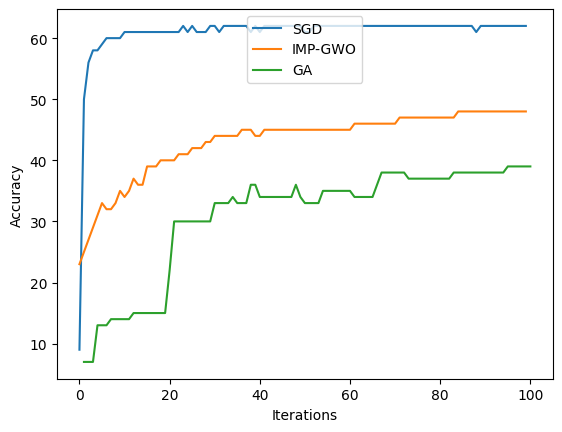

In [ ]:
import matplotlib.pyplot as plt
fig1 =  plt.figure("Accuracy over iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
x,y = zip(*accuracyList1)
plt.plot(x, y, label = 'SGD')
x,y = zip(*accuracyList2)
plt.plot(x, y, label = 'IMP-GWO')
x,y = zip(*accuracyList3)
plt.plot(x, y, label = 'GA')
leg = plt.legend(loc='upper center')
plt.show()

NSGA-II


In [21]:
#Code adapted from labs

from typing import ByteString
import random
import numpy as np
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
from deap import creator, base, tools, algorithms

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

popSize     = 300 #Population size
dimension   = 850 #Numer of decision variable x
numOfBits   = 30 #Number of bits in the decision variable
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
crossProb   = 0.85
flipProb    = 1. / (dimension * numOfBits/35) #bit mutate prob
mutateprob  = .9 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....
best = []

toolbox = base.Toolbox()


toolbox.register("attr_bool", random.randint, 0, 1)


toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def eval_network(inputs, labels, individual):

    total_loss = 0
    sep = separatevariables(individual)
    sep = np.asarray(sep)
    sep = sep.astype('float32')
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(sep[:840].reshape(10,84)))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(sep[-10:]))
    net.to(device)
    with torch.no_grad():
        out = net(inputs)
        loss = criterion(out, labels)
        total_loss+= loss.item()
    weight_sum = np.sum(np.square(sep))
    return total_loss, weight_sum

def accuracy(individual):
    sep = separatevariables(individual)
    sep = np.asarray(sep)
    sep = sep.astype('float32')
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(sep[:840].reshape(10,84)))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(sep[-10:]))
    net.to(device)
    correct = 0
    total = 10000
    with torch.no_grad():
      for data in valloader:
        inp, test = data[0].to(device), data[1].to(device)
      # calculate outputs by running images through the network
        outputs = net(inp)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == test).sum().item()

    print(f'Accuracy of the network on the 10000 validation images: {100 * correct // total} %')
    return (100 * correct // total)

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", eval_network, inputs, labels)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selNSGA2)

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-5+10*numasint/maxnum
    return numinrange

# input: concatenated list of binary variables
# output: tuple of real numbers representing those variables
def separatevariables(v):
    variablelist = []
    for i in range(0,850):
        variablelist.append(chrom2real(v[numOfBits*i:numOfBits*(i+1)]))

    return variablelist

def real2chrom(weight):
    weight=weight/20
    if weight<-1:
        weight=-1
    if weight>1:
        weight=1
    integerPart = int(maxnum * (weight + 1) / 2)
    if (integerPart == maxnum):
        integerPart -= 1
    chromosome = [int(d) for d in str(bin(integerPart))[2:]]
    while (len(chromosome) < numOfBits):
        chromosome.insert(0,0)
    indasstring=''.join(map(str, chromosome))
    chromosome=bin_to_gray(indasstring)
    output=[]
    for digit in chromosome:
        output.append(int(digit))
    #print("out",chrom2real(chromosome))
#     print(chromosome)
#     if False in chromosome:
#         print ("got false")
    return output

def main():
    #random.seed(64)



  popa = toolbox.population(n=popSize)
  pop=[]
  for ind in popa:
      sep=separatevariables(ind)
      weightlist=[]
      for weight in sep:
          weightlist+=real2chrom(weight)#/20)
      #print(weightlist)
      pop.append(creator.Individual(weightlist))
  train_batches = list(trainloader)
  # Get a random batch
  random_batch = random.choice(train_batches)
  # Extract inputs and labels from the random batch
  inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

  fitnesses = toolbox.map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

  pop = toolbox.select(pop, len(pop))


  # Variable keeping track of the number of generations
  g = 0

  # chromosone is 1 weight, an individual is 850 weights
  # Begin the evolution
  while g < iterations:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
#         for individ in pop:
#             print(individ)
        train_batches = list(trainloader)
        # Get a random batch
        random_batch = random.choice(train_batches)
        # Extract inputs and labels from the random batch
        inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

        # Select the next generation individuals
        offspring = tools.selTournamentDCD(pop, len(pop))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                #print('before crossover ',child1, child2)
                toolbox.mate(child1, child2)
                #print('after crossover ',child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        train_batches = list(trainloader)
        # Get a random batch
        random_batch = random.choice(train_batches)
        # Extract inputs and labels from the random batch
        inputs, labels = random_batch[0].to(device), random_batch[1].to(device)

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit



        #print("  Evaluated %i individuals" % len(invalid_ind))


        pop = toolbox.select(pop + offspring, popSize)



  sorted(pop, key=accuracy)
  best = pop[0]
  return best



if __name__ == "__main__":
    best = main()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

-- Generation 1 --


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 validation images: 8 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 validation images: 15 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 validation images: 9 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 validation images: 9 %


In [22]:
sep = separatevariables(best)
sep = np.asarray(sep)
sep = sep.astype('float32')
net.fc3.weight = torch.nn.Parameter(torch.from_numpy(sep[:840].reshape(10,84)))
net.fc3.bias = torch.nn.Parameter(torch.from_numpy(sep[-10:]))
net.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b75a954eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the 10000 test images: 8 %
